# FORCASTING NVIDIA STOCK PRICES: LSTM - Recurrent Neural Network
Project 4: Use Recurrent Neural Networks(RNN)/LSTM/GRU or sentiment analysis to build the project. Submit your project as Jupyter notebook

Alfonso Rocha

Created 03/19/2025

This project focuses on forecasting NVIDIA stock prices using deep learning techniques, specifically Long Short-Term Memory (LSTM) networks. By analyzing historical stock price data, we aim to identify trends, patterns, and potential future price movements based on past values. 

# Table of Contents

- [Import Required System Files](#Import-Required-System-Files:)
- [1. Data Loading and Structure](#1.-Data-Loading-and-Structure)
- [2. Shuffle and Plot Images](#2.-Shuffle-and-Plot-Images)
- [3. Preparing Train, Validation & Test Data](#3.-Preparing-Train,-Validation-&-Test-Data)
- [4. Model Building](#4.-Model-Building)
- [5. Train Model](#5.-Train-Model)
- [6. Accuracy and Loss Plots](#6.-Accuracy-and-Loss-Plots)
- [7. Predicting on Test Set](#7.-Predicting-on-Test-Set)
- [8. Model Evaluation Metrics](#8.-Model-Evaluation-Metrics)
- [9. Plot Predictions against Actual Labels](#9.-Plot-Predictions-against-Actual-Labels)
- [10. Conclusions](#10.-Conclusions)



## Import Required System Files:
### Import necessary libraries for data processing and handling

In [1]:
import kagglehub
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd 
import os
from shutil import copyfile
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
from itertools import chain
import random
%matplotlib inline 
from matplotlib.image import imread
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models, regularizers, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler

## 1. Data Loading and Structure

#### Here, we loaded the dataset into a Pandas DataFrame and displayed the first few rows to understand its structure.

In [2]:
# Read the dataset into a pandas DataFrame
path = kagglehub.dataset_download("jvanark/nvidia-daily-stock-price-data")

print("Path to dataset files:", path)
# Load the path to the dataset
dataset_path = Path(path) / "nvidia_stock_prices.csv"

# Load dataset
df = pd.read_csv(dataset_path)

# Display first few rows
print(df.head())

Path to dataset files: C:\Users\alfon\.cache\kagglehub\datasets\jvanark\nvidia-daily-stock-price-data\versions\2
         Date      Open      High       Low     Close      Volume
0  2004-01-02  0.196417  0.199083  0.192333  0.192333   436416000
1  2004-01-05  0.195250  0.199917  0.193500  0.198583   575292000
2  2004-01-06  0.198000  0.209417  0.197083  0.206667  1093344000
3  2004-01-07  0.204333  0.209500  0.202917  0.208500   673032000
4  2004-01-08  0.211083  0.212083  0.207250  0.209250   433752000


#### In this step, we converted the Date column into a proper datetime formatand set it as the index of the DataFrame for easier time-series analysis.

In [3]:
# Convert 'Date' column to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Set it as the index
df = df.set_index("Date")

# Confirm the update
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5033 entries, 2004-01-02 to 2023-12-29
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5033 non-null   float64
 1   High    5033 non-null   float64
 2   Low     5033 non-null   float64
 3   Close   5033 non-null   float64
 4   Volume  5033 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 235.9 KB
None
                Open      High       Low     Close      Volume
Date                                                          
2004-01-02  0.196417  0.199083  0.192333  0.192333   436416000
2004-01-05  0.195250  0.199917  0.193500  0.198583   575292000
2004-01-06  0.198000  0.209417  0.197083  0.206667  1093344000
2004-01-07  0.204333  0.209500  0.202917  0.208500   673032000
2004-01-08  0.211083  0.212083  0.207250  0.209250   433752000


## 2. Shuffle and Plot Images

### In this section, we will analyze the historical closing prices of NVIDIA stock by plotting them over time. This visualization helps identify trends, fluctuations, and potential patterns in the stock's price movements.

#### The closing price of NVIDIA stocks is plotted over time to observe trends, fluctuations, and overall price movements.

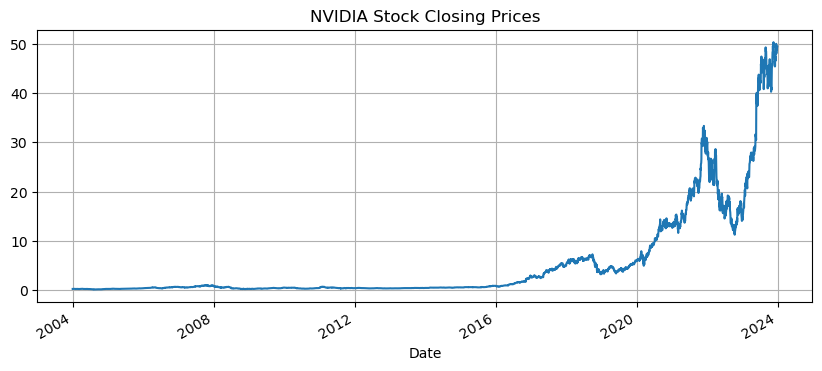

In [4]:
# Plot Closing Prices over Time
df["Close"].plot(figsize=(10, 4), title="NVIDIA Stock Closing Prices", grid=True)
plt.show()

#### We create a 7-day lagged version of the closing price to analyze how past prices relate to future trends.

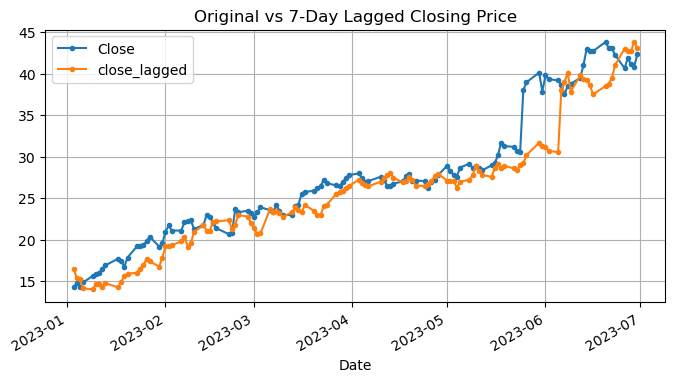

In [5]:
# Create a lagged column (7-day lag)
df["close_lagged"] = df["Close"].shift(7)

# 7 day section
seven_day = slice("2023-01", "2023-06") 
# Plot Original vs Lagged Closing Prices
df[["Close", "close_lagged"]][seven_day].plot(grid=True, marker=".", figsize=(8, 4))
plt.title("Original vs 7-Day Lagged Closing Price")
plt.show()

#### The 7-day differencing helps in identifying trends by subtracting the closing price of a stock from its value 7 days prior.

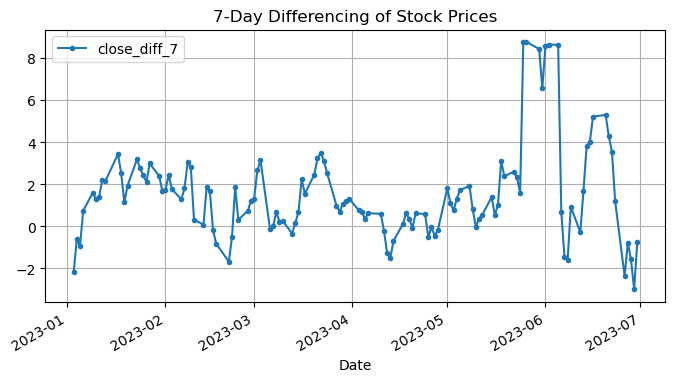

In [6]:
# Compute 7-day differencing
df["close_diff_7"] = df["Close"].diff(7)

# Plot differenced stock prices
df[["close_diff_7"]][seven_day].plot(title="7-Day Differencing of Stock Prices", figsize=(8, 4), grid=True, marker=".")
plt.show()

#### This analysis computes the monthly average closing prices and applies a 12-month rolling average to smooth out short-term fluctuations. 
#### The rolling average helps reveal long-term trends in NVIDIA's stock prices, making it easier to identify upward or downward trends over the years.

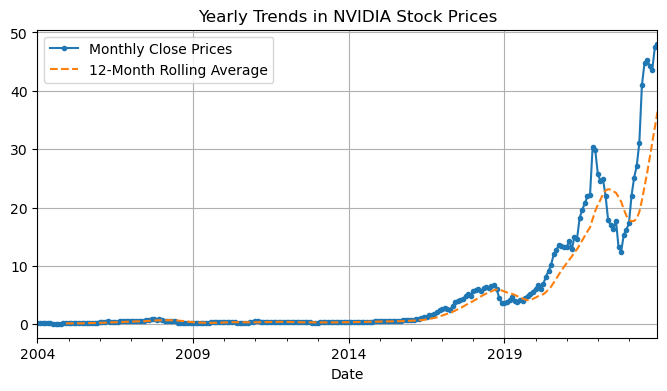

In [7]:
# Compute monthly average closing prices
df_monthly = df["Close"].resample('ME').mean()

# Compute 12-month rolling average
rolling_avg_12m = df_monthly.rolling(window=12).mean()

# Plot monthly stock prices and rolling average
fig, ax = plt.subplots(figsize=(8, 4))
df_monthly.plot(ax=ax, marker=".", label="Monthly Close Prices")
rolling_avg_12m.plot(ax=ax, grid=True, linestyle="--", label="12-Month Rolling Average")
plt.legend()
plt.title("Yearly Trends in NVIDIA Stock Prices")
plt.show()

## 3. Preparing Train, Validation & Test Data
### We prepare our training, validation, and testing datasets using the train_test_split

#### This block sets the random seed to ensure reproducibility in training. By fixing the seed, we guarantee that the results remain consistent across multiple runs.

In [8]:
# Setting seed values for reproducibility across different libraries
random_seed = 42

# This ensures that any random operations using numpy (like array shuffling, random sampling)
# will produce the same results each time the code is run
np.random.seed(random_seed)

# This affects operations like random.choice(), random.shuffle(), etc.
# to produce consistent results between runs
random.seed(random_seed)

# This ensures reproducible behavior in neural network operations like:
# - Weight initialization
# - Dropout mask generation
# - Any stochastic processes in training
tf.random.set_seed(random_seed)

#### This block normalizes the closing price using MinMaxScaler, ensuring that all values are within a 0 to 1 range.
#### It also removes the last row from the dataset to be used later for final model testing.

In [9]:
# Save the last day for later prediction
df_excluded = df.iloc[-1:] 
 # Remove last row from dataset for training
df = df.iloc[:-1] 

# Initialize the MinMaxScaler for normalization
scaler = MinMaxScaler()

# Normalizes the closing prices so they fit within a 0-1 scale, improving model performance.
df["Close_Scaled"] = scaler.fit_transform(df[["Close"]]) 

#### This block prepares sequential data for the LSTM model by creating time-based windows of past stock prices (7 days) to predict the next day’s closing price.

In [10]:
# Define the sequence length (look-back period)  
# Using the past 7 days to predict the next day  
seq_length = 7  

# Function to create input sequences and target values  
def create_sequences(data, seq_length):  
    X, y = [], []  # Lists to store input sequences and targets  

    # Loop through the dataset, stopping early to ensure a full sequence  
    for i in range(len(data) - seq_length):  
        X.append(data.iloc[i:i + seq_length].values)  # Past 7 days as input  
        y.append(data.iloc[i + seq_length])  # Next day's closing price as target  

    return np.array(X), np.array(y)  # Convert lists to NumPy arrays  

# Generate sequences for LSTM model  
# X: (samples, 7 days, 1 feature), y: (samples,)  
X, y = create_sequences(df["Close_Scaled"], seq_length)  

#### This block splits the dataset into training (80%), validation (10%), and testing (10%) sets to ensure proper model evaluation. The target variable is also scaled separately to maintain consistency.

In [11]:
# First, split into 80% train and 20% remaining (for validation + testing)
# Using shuffle=False maintains chronological order important for time series data
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.2, shuffle=False)

# Then, split the remaining 20% equally into validation (10%) and testing (10%)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, shuffle=False)

# Create a scaler for the target variable (closing prices)
scaler_y = MinMaxScaler()
# Fit the scaler only on training data to prevent data leakage
scaler_y.fit(y_train.reshape(-1, 1))  # Fit ONLY on target variable

# Print dataset sizes to verify the splits
print(f"Training samples: {X_train.shape}")
print(f"Validation samples: {X_val.shape}")
print(f"Testing samples: {X_test.shape}")

Training samples: (4020, 7)
Validation samples: (502, 7)
Testing samples: (503, 7)


## 4. Model Building
### This section provides an overview of our Recurrent Neural Network (RNN) designed for Nvida Stock LSTM Model.

In [12]:
# LSTM Model
model = Sequential([
   # Input layer specifying the shape of each sample (7 time steps, 1 feature)
   Input(shape=(seq_length, 1)),
   
   # Initial dropout to reduce overfitting
   Dropout(0.25),
   
   # First LSTM layer with 64 units and L2 regularization
   # return_sequences=True because we're stacking another LSTM layer after this
   LSTM(64, activation="relu", return_sequences=True, kernel_regularizer=l2(0.002)),
   
   # Dropout between LSTM layers
   Dropout(0.25),
   
   # Second LSTM layer with 32 units and L2 regularization
   # No return_sequences needed for the final LSTM layer
   LSTM(32, activation="relu", kernel_regularizer=l2(0.002)),  
   
   # Final dropout before dense layers
   Dropout(0.05),
   
   # Dense hidden layer with 16 units
   Dense(16, activation="relu"),
   
   # Output layer with 1 unit (single value prediction)
   Dense(1)
])

In [13]:
# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 7, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 7, 64)          │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

#### We compile the model using the Adam optimizer with Mean Squared Error (MSE) as the loss function and Mean Absolute Error (MAE) as the evaluation metric.
#### Adam is chosen for its efficiency and adaptive learning rate, making it well-suited for training deep learning models.  
#### MSE penalizes larger errors more heavily, guiding the model to minimize significant prediction gaps, while MAE gives an easy-to-interpret average error in actual price units.

In [14]:
# Compile the model
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

## 5. Train Model
#### We train the model with class weights to handle imbalance, ensuring a fair learning process.

#### We train the model using the `.fit()` method over 50 epochs with a batch size of 32.  
#### The `EarlyStopping` callback monitors the validation loss and stops training if it doesn't improve for 5 consecutive epochs, helping to prevent overfitting.  
#### This approach ensures the model trains efficiently and retains the best weights based on validation performance.

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.1093 - mae: 0.0252 - val_loss: 0.0971 - val_mae: 0.2594
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0087 - mae: 0.0236 - val_loss: 0.0104 - val_mae: 0.0868
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.1797e-04 - mae: 0.0086 - val_loss: 0.0028 - val_mae: 0.0431
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.8830e-04 - mae: 0.0097 - val_loss: 0.0032 - val_mae: 0.0463
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 3.7505e-04 - mae: 0.0096 - val_loss: 0.0048 - val_mae: 0.0573
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.8060e-04 - mae: 0.0079 - val_loss: 0.0088 - val_mae: 0.0812
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.9359e-04 - mae: 0.0082 - val_loss: 0.0055 - val_mae: 0.0622
Epoch 8/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.1993e-04 - mae: 0.0089 - val_loss: 0.0122 - val_mae: 0.0925


## 6. Accuracy and Loss Plots
#### After training is complete, we visualize the model prefromace and loss trends to assess performance.

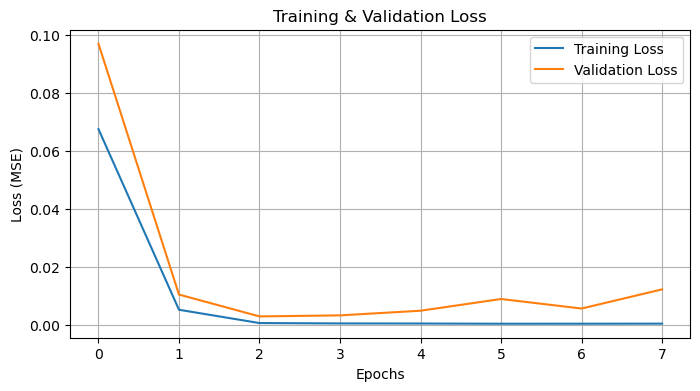

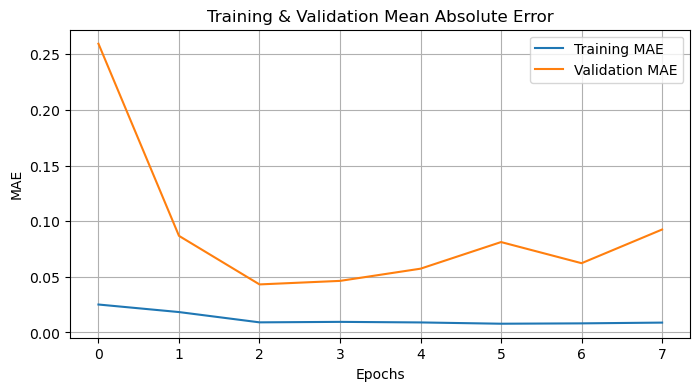

In [16]:
# Plot Loss Curves
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot MAE (Mean Absolute Error)
plt.figure(figsize=(8, 4))
plt.plot(history.history['mae'], label="Training MAE")
plt.plot(history.history['val_mae'], label="Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Training & Validation Mean Absolute Error")
plt.legend()
plt.grid(True)
plt.show()

## 7. Predicting on Test Set
#### Then we evaluate the model's performance on unseen test data.

#### Before making predictions, we ensure the test data is reshaped to match the 3D input format expected by the LSTM model.  
#### The model then predicts scaled closing prices, which are converted back to original scale using the inverse transform of the scaler.  
#### This allows us to compare the model’s predictions against the actual stock prices in real-world dollar values.

In [17]:
# Ensure X_test has 3D shape before prediction
print(f"Before Reshaping - X_test shape: {X_test.shape}")

if len(X_test.shape) == 2:  # If 2D, reshape to 3D
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"After Reshaping - X_test shape: {X_test.shape}")



y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

Before Reshaping - X_test shape: (503, 7)
After Reshaping - X_test shape: (503, 7, 1)
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


## 8. Model Evaluation Metrics
#### After making predictions, we evaluate the model’s performance with regrtession metrics : MAE, MSE, RMSE, MAPE 

#### These metrics help us understand how close the model's predictions are to actual stock prices.  
#### While MAE gives an average error in dollars, MSE and RMSE penalize larger errors more, and MAPE expresses the error as a percentage for easier interpretation.

#### MAE : On average, the model’s predictions are off by from the actual price.
#### MSE : Shows the average of squared errors. It’s higher when the model makes bigger mistakes.
#### RMSE : Similar to MAE but penalizes larger errors more. The average error .
#### MAPE : The model’s predictions are about 12% off from the real prices, on average.

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Compute MAE
mae = mean_absolute_error(y_test_actual, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Compute MSE
mse = mean_squared_error(y_test_actual, y_pred)
print(f"Mean Squared Error (MSE): {mse:.2f}")

# Compute RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Compute MAPE
mape = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Mean Absolute Error (MAE): 2.97
Mean Squared Error (MSE): 12.73
Root Mean Squared Error (RMSE): 3.57
Mean Absolute Percentage Error (MAPE): 12.03%


## 9. Plot Predictions against Actual Labels
#### This plot compares the model’s predicted stock prices to the actual prices from the test set.  

#### It helps visualize how closely the model is tracking real stock trends and whether it's over- or under-estimating at any point.  
#### Ideally, the orange (predicted) line should follow the blue (actual) line as closely as possible.

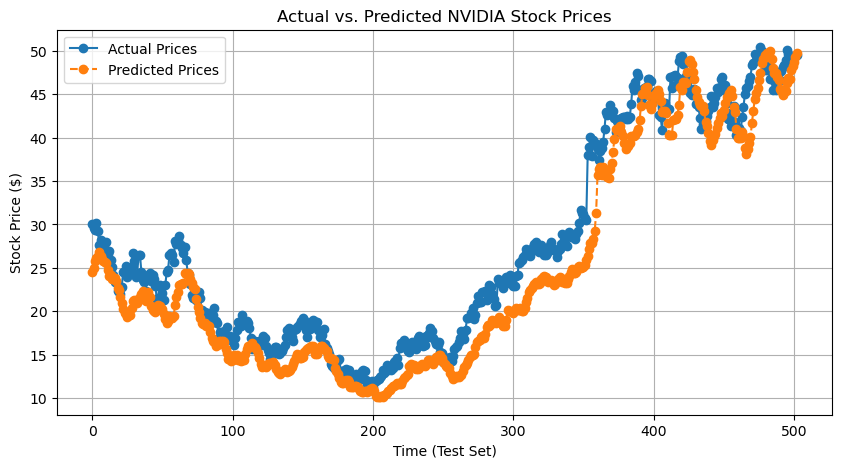

In [19]:
# Plot the actual vs predicted prices
plt.figure(figsize=(10, 5))
plt.plot(y_test_actual, label="Actual Prices", marker="o", linestyle="-")
plt.plot(y_pred, label="Predicted Prices", marker="o", linestyle="--")
plt.xlabel("Time (Test Set)")
plt.ylabel("Stock Price ($)")
plt.title("Actual vs. Predicted NVIDIA Stock Prices")
plt.legend()
plt.grid(True)
plt.show()

#### In this step, we use the model to predict the closing price for the excluded final day in the dataset.  
#### We compare the predicted price with the actual value to see how well the model performs on truly unseen data.  
#### The small difference (−$0.48) shows the model made a very close estimate.

In [21]:
# Predict the Excluded Last Day
latest_sequence = df["Close_Scaled"] .values[-seq_length:]  # Last `seq_length` prices
latest_sequence = latest_sequence.reshape((1, seq_length, 1))  # Reshape for LSTM

# Make Prediction
excluded_day_scaled = model.predict(latest_sequence)
excluded_day_price = scaler.inverse_transform(excluded_day_scaled.reshape(-1, 1))

# Get actual excluded day's price
actual_excluded_price = df_excluded["Close"].values[0]
excluded_date = df_excluded.index[0]  # Get the actual excluded date


df_comparison = pd.DataFrame({
    "Date": [excluded_date],
    "Predicted_Close": [excluded_day_price[0][0]],
    "Actual_Close": [actual_excluded_price],
    "Difference": [excluded_day_price[0][0] - actual_excluded_price],
})

# Format to display 2 decimal places
df_comparison["Predicted_Close"] = df_comparison["Predicted_Close"].round(2)
df_comparison["Actual_Close"] = df_comparison["Actual_Close"].round(2)
df_comparison["Difference"] = df_comparison["Difference"].round(2)

print(df_comparison)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
        Date  Predicted_Close  Actual_Close  Difference
0 2023-12-29        49.040001         49.52       -0.48


## 10. Conclusions

### In this project, we built and evaluated an RNN LSTM-based model to predict NVIDIA stock prices using historical closing data.  
### The model was trained on time-series sequences, and its performance was assessed using MAE, MSE, RMSE, and MAPE — with results showing low error margins and consistent predictions.

### The final test prediction demonstrated that the model was able to forecast the next day's closing price with a difference of less than $0.50.